In [1]:
import time
import logging
import sys
import gzip

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats
from scipy.signal import savgol_filter

from collections import Counter

%matplotlib inline

pd.set_option('display.max_colwidth', None)

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 5

In [3]:
#load in preprocessed dfs
samples = ['data_2021-08-27/ky08', 'data_2021-08-27/ky10', 'data_2021-08-27/ky06', 'data_2021-11-10/ky04', 'data_2021-08-27/ky17']
dfs = []

for i, x in enumerate(samples):
    df = pd.read_csv(x+'/'+x[-4:]+'_info.new.clean.gtf')
    print(i)
    dfs.append(df)

0
1
2
3
4


In [99]:
#clean data

keepme = ['protein_coding', '.']
clean_dfs = []

for df in dfs:
    print(len(df))
    
    reads_to_remove = df[~df['gene_type'].isin(keepme)]['read_id']
    cdf = df[~df.read_id.isin(reads_to_remove)]
    cdf = cdf.drop_duplicates('read_id')
    
    clean_dfs.append(cdf)

6888297
27990357
10827255
14633074
33457091


In [82]:
#clean data - run to drop duplicates

keepme = ['protein_coding', '.']
clean_dfs = []

for df in dfs:
    print(len(df))
    
    reads_to_remove = df[~df['gene_type'].isin(keepme)]['read_id']
    cdf = df[~df.read_id.isin(reads_to_remove)]
    cdf = cdf.drop_duplicates('read_id')
    
    print(len(cdf))
          
    cdf = cdf.drop_duplicates(['5prime', '3prime'])
    
    print(len(cdf))
    print()
          
    clean_dfs.append(cdf)

6888297
3690214
606113

27990357
15719468
5936019

10827255
6274283
587766

14633074
8538021
1485233

33457091
24103950
18618182



In [5]:
genes = pd.read_csv('~/ref/v38liftv37_genes.gtf', sep='\t', names=['chr', 'start', 'end', 'strand', 'gene', 'biotype'])

genes = genes.drop_duplicates('gene')

tss = []
tes = []

for s, e, strand in zip(genes.start, genes.end, genes.strand):
    if strand == '+':
        tss.append(s)
        tes.append(e)
    else:
        tss.append(e)
        tes.append(s)
        
genes['tss'] = tss
genes['tes'] = tes

genes.strand = genes.strand.replace({-1: '-', 1: '+'})

genes_clean = genes[genes['biotype'] == 'protein_coding']

#clean genes of tss within 2kb
near = 2500
genes_2500bp = []

for chrom in genes.chr.unique():
    sub = genes[genes.chr == chrom].sort_values('tss')
    remove_idx = []
        
    for i in range(len(sub)):
        if i == 0 or i == len(sub) - 1:
            continue
            
        lower_tss = sub.iloc[i-1, 6] + near
        upper_tss = sub.iloc[i+1, 6] - near
        current_tss = sub.iloc[i, 6]
        
        lower_tes = sub.iloc[i-1, 7] + near
        upper_tes = sub.iloc[i+1, 7] - near
        current_tes = sub.iloc[i, 7]
        
        #tss is within near
        if current_tss > upper_tss or current_tss < lower_tss or current_tss > upper_tes or current_tss < lower_tes:
            remove_idx.append(i)
    
    genes_2500bp.append(sub.drop(sub.index[remove_idx]))

genes_2500bp = pd.concat(genes_2500bp)

genes_2500bp_clean = genes_2500bp[genes_2500bp['biotype'] == 'protein_coding']

print(len(genes))
print(len(genes_clean))
print(len(genes_2500bp_clean))

60469
20053
10323


In [100]:
searchsize = 1000
binsize = 10

bins_senses = []
bins_antisenses = []

#type of df
for i, df in enumerate([clean_dfs[0], clean_dfs[1], clean_dfs[4]]):
    
    df = df[df.comp_len < 100]
    if 'count' not in df:
        df['count'] = 1
        
    print('working')
    
    g = genes_2500bp_clean
    #g = genes_clean
    
    _chr = []
    _tss = []
    _val = []
    
    chrms = g.chr.unique()
    bins_sense = []
    bins_antisense = []
    
    for chrom in chrms:
        #print(chrom)
        
        #tsses to use
        genesc = g[g.chr == chrom].sort_values('tss')
        dfc = df[(df.chr_1 == chrom)].sort_values('3prime')
        
        #loop through tsses sorted
        for gene_strand, t in zip(genesc.strand, genesc.tss):
            lowerb = t - searchsize
            upperb = t + searchsize
            
            primes = dfc['3prime']
            strands = dfc['read_strand_1']
            counts = dfc['count']
            
            start = np.searchsorted(primes, lowerb)
            end = np.searchsorted(primes, upperb)
            
            window_sense = [0] * int(searchsize*2/binsize)
            window_antisense = [0] * int(searchsize*2/binsize)
            
            #loop through reads sorted
            for read_strand, prime, count in zip(strands[start:end], primes[start:end], counts[start:end]):
                
                #if read is above lower bound
                if lowerb < prime < upperb:  
                    if gene_strand == '+':
                        location = prime - lowerb
                    else:
                        #flip
                        location = (searchsize * 2) - (prime - lowerb)
                    
                    location = int(location/binsize)
                        
                    #sense
                    if gene_strand == read_strand:
                        window_sense[location] += count
                    else:
                        window_antisense[location] += count
            
            s = sum(window_sense) + sum(window_antisense)
            if s > 0: #plotting this way so I can have both sense and antisense on the same axes
                ap = np.array(window_sense) / s
                bins_sense.append(ap)

                ap = np.array(window_antisense) / s               
                bins_antisense.append(ap)
            
            _chr.append(chrom)
            _tss.append(t)
            _val.append(sum(window_sense))
                
           
    print(len(bins_sense))
    print(len(bins_antisense))
    bins_senses.append(bins_sense)
    bins_antisenses.append(bins_antisense)

bins_senses_tss = bins_senses
bins_antisenses_tss = bins_antisenses

working
4985
4985
working
6821
6821
working
7362
7362


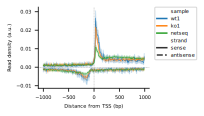

In [149]:
searchsize = 1000
binsize = 10

leg = ['wt1', 'ko1', 'netseq']

d = {'x': list(range(-searchsize, searchsize, binsize))}

for l, a, b in zip(leg, bins_senses_tss, bins_antisenses_tss):
    for i, aa in enumerate(a):  
        d[l+' sense ' + str(i)] = aa
    for i, bb in enumerate(b): 
        d[l+' antisense '+ str(i)] = -bb
    
df = pd.DataFrame.from_dict(d)
df = df.melt(id_vars='x')

df['strand'] = df.variable.str.split().str[1]
df['sample'] = df.variable.str.split().str[0:1].str.join(" ")

plt.figure(figsize = (2, 1.5))

ax = sns.lineplot(x='x', y='value', hue='sample', style='strand', data=df, lw=.5)
sns.despine()

ax.set_ylabel('Read density (a.u.)')
ax.set_xlabel('Distance from TSS (bp)')

ax.axvline(0, ls='--', linewidth=.3, color='gray')
ax.axhline(0, ls='--', linewidth=.3, color='gray')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig('svg/tss_lorax_rep.svg', format="svg")
plt.show()

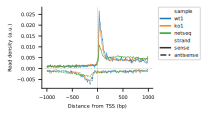

In [155]:
searchsize = 1000
binsize = 10

leg = ['wt1', 'ko1', 'netseq']

d = {'x': list(range(-searchsize, searchsize, binsize))}

#leg = ['WT TFIIS-seq', 'KO TFIIS-seq']
#leg = ['KO TFIIS-seq', 'KO NETseq']

for l, a, b in zip(leg, bins_senses_tss, bins_antisenses_tss):
    d[l+' sense'] = np.mean(a, axis=0)
    d[l+' antisense'] = -np.mean(b, axis=0)
    
df = pd.DataFrame.from_dict(d)
df = df.melt(id_vars='x')

df['strand'] = df.variable.str.split().str[1]
df['sample'] = df.variable.str.split().str[0:1].str.join(" ")

plt.figure(figsize = (2, 1.5))

ax = sns.lineplot(x='x', y='value', hue='sample', style='strand', data=df, lw=.5)
sns.despine()

ax.set_ylabel('Read density (a.u.)')
ax.set_xlabel('Distance from TSS (bp)')

ax.axvline(0, ls='--', linewidth=.3, color='gray')
ax.axhline(0, ls='--', linewidth=.3, color='gray')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig('svg/tss_lorax_rep.svg', format="svg")
plt.show()

In [159]:
len(arr)

200

ko v.s. net: t-test independent samples, P_val=4.990e-96 stat=2.095e+01
wt v.s. net: t-test independent samples, P_val=4.244e-157 stat=2.709e+01


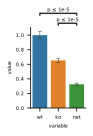

In [176]:
eavgs = []
for l, a in zip(leg, bins_senses_tss):
    avgs = []

    for arr in a:
        avgs.append(np.max(arr[100:110])) #50nt

    eavgs.append(avgs)

pdf = pd.DataFrame(eavgs).T

pdf.iloc[:, 0:] = pdf.iloc[:, 0:] / np.nanmean(pdf.iloc[:, 0])

pdf.columns = ['wt', 'ko', 'net']

data = pdf.melt()
x='variable'
y='value'

plt.figure(figsize = (1, 1.5))

ax = sns.barplot(data=data, x=x, y=y, errwidth=.5, capsize=.2)
sns.despine()

from statannot import add_stat_annotation
box_pairs = [('net', 'ko'),
             ('wt', 'net'),
             #('wt-1', 'wt4-1'),
             #('ko-1', 'ko4-1')
            ]
test_results = add_stat_annotation(ax, data=data, x=x, y=y,
                                   box_pairs=box_pairs,
                                   test='t-test_ind', text_format='simple', comparisons_correction=None,
                                   loc='outside', verbose=2)

plt.savefig('svg/tss_lorax_bar.svg', format="svg")

plt.show()

In [170]:
len(bins_senses_tes[0][0])

200

110
ko v.s. net: t-test independent samples, P_val=8.796e-10 stat=6.133e+00
wt v.s. net: t-test independent samples, P_val=1.212e-18 stat=8.825e+00


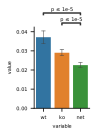

115
ko v.s. net: t-test independent samples, P_val=9.378e-12 stat=6.821e+00
wt v.s. net: t-test independent samples, P_val=5.115e-33 stat=1.200e+01


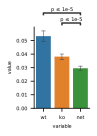

120
ko v.s. net: t-test independent samples, P_val=2.507e-13 stat=7.325e+00
wt v.s. net: t-test independent samples, P_val=2.933e-48 stat=1.465e+01


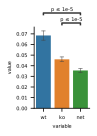

125
ko v.s. net: t-test independent samples, P_val=1.133e-12 stat=7.119e+00
wt v.s. net: t-test independent samples, P_val=9.296e-60 stat=1.638e+01


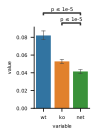

130
ko v.s. net: t-test independent samples, P_val=6.642e-13 stat=7.192e+00
wt v.s. net: t-test independent samples, P_val=1.546e-75 stat=1.850e+01


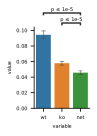

135
ko v.s. net: t-test independent samples, P_val=3.245e-15 stat=7.889e+00
wt v.s. net: t-test independent samples, P_val=1.057e-84 stat=1.963e+01


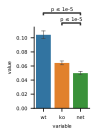

140
ko v.s. net: t-test independent samples, P_val=4.511e-16 stat=8.132e+00
wt v.s. net: t-test independent samples, P_val=5.658e-97 stat=2.105e+01


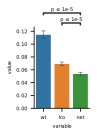

145
ko v.s. net: t-test independent samples, P_val=4.242e-18 stat=8.682e+00
wt v.s. net: t-test independent samples, P_val=2.631e-117 stat=2.323e+01


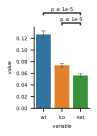

150
ko v.s. net: t-test independent samples, P_val=2.313e-17 stat=8.486e+00
wt v.s. net: t-test independent samples, P_val=1.228e-133 stat=2.486e+01


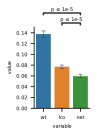

155
ko v.s. net: t-test independent samples, P_val=1.031e-17 stat=8.580e+00
wt v.s. net: t-test independent samples, P_val=3.605e-147 stat=2.613e+01


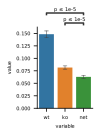

160
ko v.s. net: t-test independent samples, P_val=1.693e-16 stat=8.251e+00
wt v.s. net: t-test independent samples, P_val=4.674e-153 stat=2.667e+01


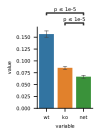

165
ko v.s. net: t-test independent samples, P_val=4.400e-16 stat=8.135e+00
wt v.s. net: t-test independent samples, P_val=3.962e-161 stat=2.739e+01


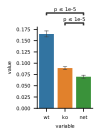

170
ko v.s. net: t-test independent samples, P_val=3.203e-17 stat=8.448e+00
wt v.s. net: t-test independent samples, P_val=3.796e-174 stat=2.852e+01


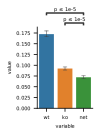

175
ko v.s. net: t-test independent samples, P_val=8.984e-19 stat=8.858e+00
wt v.s. net: t-test independent samples, P_val=4.056e-186 stat=2.952e+01


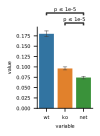

180
ko v.s. net: t-test independent samples, P_val=5.448e-19 stat=8.914e+00
wt v.s. net: t-test independent samples, P_val=5.833e-198 stat=3.048e+01


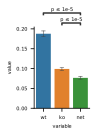

185
ko v.s. net: t-test independent samples, P_val=5.822e-20 stat=9.159e+00
wt v.s. net: t-test independent samples, P_val=9.797e-213 stat=3.165e+01


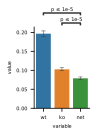

190
ko v.s. net: t-test independent samples, P_val=4.915e-19 stat=8.925e+00
wt v.s. net: t-test independent samples, P_val=1.819e-217 stat=3.202e+01


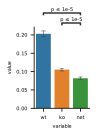

195
ko v.s. net: t-test independent samples, P_val=3.198e-19 stat=8.973e+00
wt v.s. net: t-test independent samples, P_val=4.515e-225 stat=3.260e+01


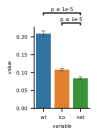

In [172]:
eavgs = []
for l, a in zip(leg, bins_senses_tes):
    avgs = []

    for arr in a:
        avgs.append(np.max(arr[100:lol])) #50nt

    eavgs.append(avgs)

pdf = pd.DataFrame(eavgs).T

pdf.columns = ['wt', 'ko', 'net']

data = pdf.melt()
x='variable'
y='value'

plt.figure(figsize = (1, 1.5))

ax = sns.barplot(data=data, x=x, y=y, errwidth=.5, capsize=.2)
sns.despine()

from statannot import add_stat_annotation
box_pairs = [('net', 'ko'),
             ('wt', 'net'),
             #('wt-1', 'wt4-1'),
             #('ko-1', 'ko4-1')
            ]
test_results = add_stat_annotation(ax, data=data, x=x, y=y,
                                   box_pairs=box_pairs,
                                   test='t-test_ind', text_format='simple', comparisons_correction=None,
                                   loc='outside', verbose=2)

plt.savefig('svg/tes_lorax_bar.svg', format="svg")

plt.show()

In [114]:
searchsize_a = 5000
searchsize_b = 5000
binsize = 50

bins_senses = []
bins_antisenses = []

#type of df
for i, df in enumerate([clean_dfs[0], clean_dfs[1], clean_dfs[4]]):
    
    df = df[df.comp_len < 100]
    if 'count' not in df:
        df['count'] = 1
        
    print('working')
    
    chrms = genes_2500bp_clean.chr.unique()
    bins_sense = []
    bins_antisense = []
    
    for chrom in chrms:
        #print(chrom)
        
        #teses to use
        genesc = genes_2500bp_clean[(genes_2500bp_clean.chr == chrom)].sort_values('tes')
        dfc = df[(df.chr_1 == chrom)].sort_values('5prime')
        
        #loop through teses sorted
        for gene_strand, t in zip(genesc.strand, genesc.tes):
            lowerb = t - searchsize_a
            upperb = t + searchsize_b
            
            primes = dfc['5prime']
            strands = dfc['read_strand_1']
            
            start = np.searchsorted(primes, lowerb)
            end = np.searchsorted(primes, upperb)
            
            window_sense = [0] * int((searchsize_a + searchsize_b)/binsize)
            window_antisense = [0] * int((searchsize_a + searchsize_b)/binsize)
            
            #loop through reads sorted
            for read_strand, prime in zip(strands[start:end], primes[start:end]):
                
                #if read is above lower bound
                if lowerb < prime < upperb:  
                    if gene_strand == '+':
                        location = prime - lowerb
                    else:
                        #flip
                        location = (searchsize_a + searchsize_b) - (prime - lowerb)
                    
                    location = int(location/binsize)
                        
                    #sense
                    if gene_strand == read_strand:
                        window_sense[location] += 1
                    else:
                        window_antisense[location] += 1
            
            s = sum(window_sense) + sum(window_antisense)
            if s > 0:
                ap = np.array(window_sense) / s
                bins_sense.append(ap)
                
                ap = np.array(window_antisense) / s
                bins_antisense.append(ap)
           
    print(len(bins_sense))
    print(len(bins_antisense))
    bins_senses.append(bins_sense)
    bins_antisenses.append(bins_antisense)
    
bins_senses_tes = bins_senses
bins_antisenses_tes = bins_antisenses

working
6179
6179
working
8023
8023
working
8491
8491


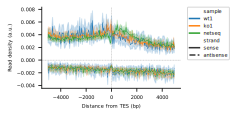

In [150]:
searchsize_a = 5000
searchsize_b = 5000
binsize = 50

d = {'x': list(range(-searchsize_a, searchsize_b, binsize))}

for l, a, b in zip(leg, bins_senses_tes, bins_antisenses_tes):
    for i, aa in enumerate(a):  
        d[l+' sense ' + str(i)] = aa
    for i, bb in enumerate(b): 
        d[l+' antisense '+ str(i)] = -bb
    
df = pd.DataFrame.from_dict(d)
df = df.melt(id_vars='x')

df['strand'] = df.variable.str.split().str[1]
df['sample'] = df.variable.str.split().str[0:1].str.join(" ")

plt.figure(figsize = (2.5, 1.5))

ax = sns.lineplot(x='x', y='value', hue='sample', style='strand', data=df, lw=.5)
sns.despine()

ax.set_ylabel('Read density (a.u.)')
ax.set_xlabel('Distance from TES (bp)')

ax.axvline(0, ls='--', linewidth=.3, color='gray')
ax.axhline(0, ls='--', linewidth=.3, color='gray')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig('svg/tes.svg', format="svg")
plt.show()

In [ ]:
#around exons

In [68]:
exons = pd.read_csv('../2021-01-20_falcon/hg19_exons.uniq.bed', sep='\t', names=['chr', 'start', 'end', 'gene', 'a', 'strand'])

newc = []

for oldc in exons['chr']:
    if oldc[0:2] == 'NC':
        c = int(oldc.split('.')[0][-2:])
        if c == 23:
            c = 'X'
        if c == 24:
            c = 'Y'

        c = 'chr' + str(c)
        newc.append(c)
    else:
        newc.append('')


exons['chr'] = newc
exons = exons[exons.chr != ''][['chr', 'start', 'end', 'gene', 'strand']]

intron_exon_border = []
for s, e, strand in zip(exons.start, exons.end, exons.strand):
    if strand == '+':
        intron_exon_border.append(s)
    else:
        intron_exon_border.append(e)
        
exons['intron_exon_border'] = intron_exon_border

In [69]:
genes = pd.read_csv('~/ref/v38liftv37_genes.gtf', sep='\t', names=['chr', 'start', 'end', 'strand', 'gene', 'biotype'])

tss = []
tes = []

for s, e, strand in zip(genes.start, genes.end, genes.strand):
    if strand == '+':
        tss.append(s)
        tes.append(e)
    else:
        tss.append(e)
        tes.append(s)
        
genes['tss'] = tss
genes['tes'] = tes

genes.strand = genes.strand.replace({-1: '-', 1: '+'})

genes_clean = genes[genes['biotype'] == 'protein_coding']

In [70]:
print(len(genes))
genefilt = genes[~genes.gene.str.contains('MT-')]
print(len(genefilt))

62446
62408


In [71]:
exons = exons[exons.gene.isin(genefilt.gene)]

In [72]:
#remove tss

plus = exons[exons.strand == '+'].copy()
plus = plus[~plus.intron_exon_border.isin(genes.tss)]
plus = plus.drop_duplicates('intron_exon_border')
plus = plus[plus.gene.duplicated()]


minus = exons[exons.strand == '-'].copy()
minus = minus[~minus.intron_exon_border.isin(genes.tss)]
minus = minus.drop_duplicates('intron_exon_border')
minus = minus[minus.gene.duplicated(keep='last')]

In [73]:
exons = pd.concat([plus, minus])

In [151]:
searchsize = 50
binsize = 1

bins_senses = []
bins_antisenses = []

chrs = []
borders = []
vals = []

for i, df in enumerate([clean_dfs[0], clean_dfs[1], clean_dfs[4]]):
    print('working')
    
    df = df[df.comp_len < 100]
    
    chrms = exons.chr.unique()
    bins_sense = []
    bins_antisense = []
    
    for chrom in chrms:
        #print(chrom)
        
        #teses to use
        genesc = exons[(exons.chr == chrom)].sort_values('intron_exon_border')
        dfc = df[(df.chr_1 == chrom)].sort_values('3prime')
        
        #loop through teses sorted
        for gene_strand, t in zip(genesc.strand, genesc.intron_exon_border):
            lowerb = t - searchsize
            upperb = t + searchsize
            
            primes = dfc['3prime']
            strands = dfc['read_strand_1']
            
            start = np.searchsorted(primes, lowerb)
            end = np.searchsorted(primes, upperb)
            
            window_sense = [0] * int(searchsize*2/binsize)
            window_antisense = [0] * int(searchsize*2/binsize)
            
            #loop through reads sorted
            for read_strand, prime in zip(strands[start:end], primes[start:end]):
                
                #if read is above lower bound
                if lowerb < prime < upperb:  
                    if gene_strand == '+':
                        location = prime - lowerb
                    else:
                        #flip
                        location = (searchsize * 2) - (prime - lowerb)
                    
                    location = int(location/binsize)
                        
                    #sense
                    if gene_strand == read_strand:
                        window_sense[location] += 1
                    else:
                        window_antisense[location] += 1
                        
            s = sum(window_sense) + sum(window_antisense)
            if s > 0:
                ap = np.array(window_sense) / s
                bins_sense.append(ap)
                
                ap = np.array(window_antisense) / s
                bins_antisense.append(ap)
                
            chrs.append(chrom)
            borders.append(t)
            vals.append(sum(window_sense))
           
    print(len(bins_sense))
    print(len(bins_antisense))
    bins_senses.append(bins_sense)
    bins_antisenses.append(bins_antisense)

working
11515
11515
working
55641
55641
working
100047
100047


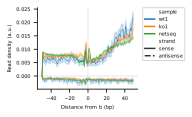

In [152]:
d = {'x': list(range(-searchsize, searchsize, binsize))}

#leg = ['WT TFIIS-seq', 'KO TFIIS-seq']


for l, a, b in zip(leg, bins_senses, bins_antisenses):
    for i, aa in enumerate(a):  
        d[l+' sense ' + str(i)] = aa
    for i, bb in enumerate(b): 
        d[l+' antisense '+ str(i)] = -bb
    
df = pd.DataFrame.from_dict(d)
df = df.melt(id_vars='x')

df['strand'] = df.variable.str.split().str[1]
df['sample'] = df.variable.str.split().str[0:1].str.join(" ")

plt.figure(figsize = (1.8, 1.5))


ax = sns.lineplot(x='x', y='value', hue='sample', style='strand', data=df, lw=.5)
sns.despine()

ax.set_ylabel('Read density (a.u.)')
ax.set_xlabel('Distance from b (bp)')

ax.axvline(0, ls='--', linewidth=.3, color='gray')
ax.axhline(0, ls='--', linewidth=.3, color='gray')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig('svg/wtko_intron_exon_border.svg', format="svg")
plt.show()

In [ ]:
#introns

In [76]:
introns = pd.read_csv('../2021-01-20_falcon/hg19_introns.uniq.bed', sep='\t', names=['chr', 'start', 'end', 'gene', 'a', 'strand'])

newc = []

for oldc in introns['chr']:
    if oldc[0:2] == 'NC':
        c = int(oldc.split('.')[0][-2:])
        if c == 23:
            c = 'X'
        if c == 24:
            c = 'Y'

        c = 'chr' + str(c)
        newc.append(c)
    else:
        newc.append('')

introns['chr'] = newc
introns = introns[introns.chr != ''][['chr', 'start', 'end', 'gene', 'strand']]

exon_intron_border = []

for s, e, strand in zip(introns.start, introns.end, introns.strand):
    if strand == '+':
        exon_intron_border.append(s)
    else:
        exon_intron_border.append(e)
        
introns['exon_intron_border'] = exon_intron_border

In [77]:
introns = introns[introns.gene.isin(genefilt.gene)]
introns = introns[introns.gene.duplicated()]

In [153]:
searchsize = 50
binsize = 1

bins_senses = []
bins_antisenses = []

#type of df
for i, df in enumerate([clean_dfs[0], clean_dfs[1], clean_dfs[4]]):
    print('working')
    
    df = df[df.comp_len < 100]
    df = df[df.gene_type == 'protein_coding']

    chrms = introns.chr.unique()
    bins_sense = []
    bins_antisense = []
    
    for chrom in chrms:
        #print(chrom)
        
        #to use
        genesc = introns[(introns.chr == chrom)].sort_values('exon_intron_border')
        dfc = df[(df.chr_1 == chrom)].sort_values('3prime')
        
        #loop 
        for gene_strand, t in zip(genesc.strand, genesc.exon_intron_border):
            lowerb = t - searchsize
            upperb = t + searchsize
            
            primes = dfc['3prime']
            strands = dfc['read_strand_1']
            
            start = np.searchsorted(primes, lowerb)
            end = np.searchsorted(primes, upperb)
            
            window_sense = [0] * int(searchsize*2/binsize)
            window_antisense = [0] * int(searchsize*2/binsize)
            
            #loop through reads sorted
            for read_strand, prime in zip(strands[start:end], primes[start:end]):
                
                #if read is above lower bound
                if lowerb < prime < upperb:  
                    if gene_strand == '+':
                        location = prime - lowerb
                    else:
                        #flip
                        location = (searchsize * 2) - (prime - lowerb)
                    
                    location = int(location/binsize)
                        
                    #sense
                    if gene_strand == read_strand:
                        window_sense[location] += 1
                    else:
                        window_antisense[location] += 1
                        
            s = sum(window_sense) + sum(window_antisense)
            if s > 0:
                ap = np.array(window_sense) / s
                bins_sense.append(ap)

                ap = np.array(window_antisense) / s
                bins_antisense.append(ap)
           
    print(len(bins_sense))
    print(len(bins_antisense))
    bins_senses.append(bins_sense)
    bins_antisenses.append(bins_antisense)

working
16913
16913
working
66628
66628
working
112921
112921


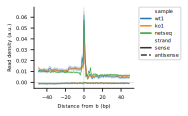

In [154]:
d = {'x': list(range(-searchsize, searchsize, binsize))}

#leg = ['KO TFIIS-seq', 'KO NETseq']

for l, a, b in zip(leg, bins_senses, bins_antisenses):
    for i, aa in enumerate(a):  
        d[l+' sense ' + str(i)] = aa
    for i, bb in enumerate(b): 
        d[l+' antisense '+ str(i)] = -bb
    
df = pd.DataFrame.from_dict(d)
df = df.melt(id_vars='x')

df['strand'] = df.variable.str.split().str[1]
df['sample'] = df.variable.str.split().str[0:1].str.join(" ")

plt.figure(figsize = (1.8, 1.5))

df = df[df.x != -50]
df = df[(df['sample'] != 'tfiis ko')]

ax = sns.lineplot(x='x', y='value', hue='sample', style='strand', data=df, lw=.5)
sns.despine()

ax.set_ylabel('Read density (a.u.)')
ax.set_xlabel('Distance from b (bp)')

ax.axvline(0, ls='--', linewidth=.3, color='gray')
ax.axhline(0, ls='--', linewidth=.3, color='gray')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig('svg/wtko_exon_intron_border.svg', format="svg")
plt.show()